This notebook includes the entire standalone code to run single particle simulations and make plot (cell 4). It is followed by a demonstration of how one can plot the data generated by simulations.

In [4]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sin, cos, pi, sqrt
from tqdm.notebook import tqdm
from matplotlib.ticker import LogLocator

# All of the code in the cell below is decleration of required functions for simulations. You can just run it.
One does not necessarily need to understand how exactly they work to use the notebook. The rest of the notebook will have descriptions of how simulations are run with different parameters. The notebook also includes differebt types of plotting.

In [5]:
# define the necessary functions
def get_points_on_circle(n, r, start_angle=0):
    """
    Returns an array of points on a circle, used for simulating
    black hole orbital motion
    
    Parameters:
    n: Number of points on the circle. More points will mean smaller time steps.
    r: Radius of the circle
    start_angle (default 0): What angle (in radians) the array of circular points
    start. The convention is counter clockwise from horizontal axis.
    
    Returns:
    xs: x coordinates of the points.
    ys: y coordinates of the points.
    """
    xs = []
    ys = []
    for i in range(n):
        angle = start_angle + (2 * pi* i / n)
        x_temp = r * cos(angle)
        y_temp = r * sin(angle)
        xs.append(x_temp)
        ys.append(y_temp)
    return xs, ys

def calculate_bary_center(u, b):
    """
    Calculates the bary center of two bodies that are 2b apart.
    For simulations of different mass black holes, the bary center is
    used as the origin.
    
    Parameters:
    u: Ratio of the first mass to total mass M1 / (M1 + M2)
    b: Half of the total distance between two black holes. 
    This iss the orbital radius if u=0
    
    Returns:
    The bary center coordinate.
    

    """
    return 2 * b * u - b

def calculate_theoretical_axial_freq(u, b, G=6.6743e-11, M=50*2e+30):
    """
    Calculates the axial frequency of an object in the trap under the
    simple harmonic motion assumption.
    
    Parameters:
    u: Ratio of the first mass to total mass M1 / (M1 + M2)
    b: Half of the total distance between two black holes.
    G: Gravitational constant
    M: Half of the total mass.
    """
    bc = calculate_bary_center(u, b)
    r_b2 = abs(- b - bc)
    r_b1 = abs(b - bc)
    w_axial = sqrt((2*u) * G * M / (r_b1 ** 3) + (2*(1-u)) * G * M / (r_b2 ** 3))
    return w_axial


def calculate_grav_electric_force(x_p, y_p, z_p,
                                  x_b1, x_b2, y_b1, y_b2,
                                  u=0.5, q=1.6e-19, Q=0.0741778,
                                  M=2e+30, m=9.109e-31,
                                  G=6.6743e-11, k=8.99e9):
    """
    Compute the net (radial) force on a charged particle from two point sources
    that combine gravity and Coulomb attraction/repulsion in a single effective term.

    Description
    ----------
    This models two “black holes” (or point masses/charges) located at (x_b1, y_b1, 0)
    and (x_b2, y_b2, 0). The particle is at (x_p, y_p, z_p). Each source exerts a
    central force along the source→particle line. The gravitational and electric
    magnitudes are folded together into a single effective strength:
        g = | G M m − k Q q |
    Then the per-source contribution is scaled by 2u for source 1 and 2(1−u) for source 2.

    Notes
    -------
    - The absolute value in `g = abs(G*M*m - k*Q*q)` removes the physical sign of
      gravitational vs. Coulomb forces and forces everything to be attractive along
      the source→particle line. If you intend the EM interaction to sometimes repel,
      you should carry the sign instead of `abs(...)` (and/or make the direction
      consistent with the intended physics).
    - There is no self-consistency check for division by zero when the particle sits
      exactly on a source (r_1 or r_2 = 0).

    Parameters
    ----------
    x_p, y_p, z_p : float
        Particle position (meters).
    x_b1, y_b1 : float
        Coordinates of source 1 in the x–y plane (meters). z is assumed 0.
    x_b2, y_b2 : float
        Coordinates of source 2 in the x–y plane (meters). z is assumed 0.
    u : float, optional
        Weighting between sources (0 ≤ u ≤ 1). Source 1 gets 2u, source 2 gets 2(1−u).
    q, Q : float, optional
        Particle charge and source charge magnitude (Coulombs).
    M, m : float, optional
        Source mass (per source, if you intend equal masses) and particle mass (kg).
    G : float, optional
        Gravitational constant (SI).
    k : float, optional
        Coulomb constant (SI).

    Returns
    -------
    tuple of floats
        (f_x, f_y, f_z) — Cartesian components of the total force on the particle (Newtons).
    """
    # Effective magnitude combining gravity and electrostatics in a single scalar.
    # NOTE: The abs() drops sign information; keep this if you truly want a purely attractive magnitude.
    g = abs(G * M * m - k * Q * q)

    # Distances from each source to the particle (sources lie in z=0 plane).
    r_1 = ((x_b1 - x_p) ** 2 + (y_b1 - y_p) ** 2 + (0 - z_p) ** 2) ** 0.5
    r_2 = ((x_b2 - x_p) ** 2 + (y_b2 - y_p) ** 2 + (0 - z_p) ** 2) ** 0.5

    # If r_1 or r_2 == 0, this will divide by zero.

    # Force from source 1: magnitude ~ g/r^2, direction ~ (r_hat)
    F_1px = (2 * u) * (g / (r_1 ** 2)) * ((x_b1 - x_p) / r_1)
    F_1py = (2 * u) * (g / (r_1 ** 2)) * ((y_b1 - y_p) / r_1)
    F_1pz = (2 * u) * (g / (r_1 ** 2)) * ((0 - z_p) / r_1)

    # Force from source 2
    F_2px = (2 * (1 - u)) * (g / (r_2 ** 2)) * ((x_b2 - x_p) / r_2)
    F_2py = (2 * (1 - u)) * (g / (r_2 ** 2)) * ((y_b2 - y_p) / r_2)
    F_2pz = (2 * (1 - u)) * (g / (r_2 ** 2)) * ((0 - z_p) / r_2)

    # Total
    f_x = F_1px + F_2px
    f_y = F_1py + F_2py
    f_z = F_1pz + F_2pz
    return f_x, f_y, f_z


def calculate_magnetic_force(q, v, B):
    """
    Lorentz magnetic force for a point charge in a static magnetic field.

    Description
    ----------
    Computes **F = q (v × B)** and returns the Cartesian components.

    Parameters
    ----------
    q : float
        Particle charge (C).
    v : array_like, shape (3,)
        Particle velocity vector (m/s).
    B : array_like, shape (3,)
        Magnetic field vector (Tesla).

    Returns
    -------
    tuple of floats
        (f_x, f_y, f_z) — Magnetic force components (Newtons).

    Notes
    -----
    - `np.cross(v, B)` returns a length-3 array; unpacking works if it’s exactly 3D.
    - Ensure `v` and `B` are 3-component arrays; lists work but NumPy arrays are safer.
    """
    f_x, f_y, f_z = q * np.cross(v, B)
    return f_x, f_y, f_z


def calculate_acceleration_3d(f_x, f_y, f_z, m):
    """
    Convert force components to acceleration components via Newton's second law.

    Parameters
    ----------
    f_x, f_y, f_z : float
        Force components (Newtons).
    m : float
        Particle mass (kg).

    Returns
    -------
    tuple of floats
        (a_x, a_y, a_z) — Acceleration components (m/s^2).

    Notes
    -----
    - No division-by-zero protection: ensure `m > 0`.
    """
    return f_x / m, f_y / m, f_z / m


def calculate_period_grav(M=2e30, G=6.6743e-11, b=1.5e10):
    """
    Orbital period of two equal masses on a circular binary of separation 2b.

    Description
    ----------
    For two equal masses on a circular orbit with separation 2b (each mass at radius b),
    this uses ω = sqrt(G M / (4 b^3)) for the orbital angular frequency, then
    T = 2π / ω.

    Parameters
    ----------
    M : float, optional
        Mass of one component (kg) if your ω formula assumes that. (Your code uses M as in ω = sqrt(G M / (4 b^3)).)
    G : float, optional
        Gravitational constant (SI).
    b : float, optional
        Half-separation of the binary (meters). Full separation is 2b.

    Returns
    -------
    float
        Orbital period T (seconds).

    Notes
    -----
    - Be consistent with the interpretation of `M`. If the true two-body problem is intended,
      check whether the formula should use total mass (2M) or individual mass (M).
    """
    omega_grav = np.sqrt(G * M / (4 * b ** 3))  # Orbital frequency of black holes
    period_grav = 2 * np.pi / omega_grav
    return period_grav


def calculate_bh_time(t, u=0.75, b=3e10, omega_grav=1):
    """
    Compute the instantaneous 2D positions of two orbiting black holes (in the z=0 plane).

    Description
    ----------
    Returns the Cartesian coordinates (x_b1, y_b1) and (x_b2, y_b2) at time `t` for a
    circular binary whose components are initially located at +b and −b on the x-axis.
    The orbital phase of the second body is offset by π (i.e., opposite side of the orbit).
    The orbits are centered on the **barycenter** along the x-axis, which is computed via
    `calculate_bary_center(u, b)` and used to set the radii:
        r_b1 = | +b − bc |,  r_b2 = | −b − bc |,
    ensuring the common center of mass remains fixed at `bc`.

    This function is vectorized in `t`: it accepts a scalar time or an array of times.

    Parameters
    ----------
    t : float or array_like
        Time(s) at which to evaluate the positions (seconds).
    u : float, optional
        Mass/weighting parameter in [0, 1], consistent with the rest of the codebase.
        Interpreted by `calculate_bary_center(u, b)` to place the COM on the x-axis.
        (For equal masses, u=0.5 and the barycenter is at x=0.)
    b : float, optional
        Half-separation of the binary (meters). The initial positions at t=0 are (+b, 0)
        and (−b, 0) before shifting by the barycenter.
    omega_grav : float, optional
        Orbital angular frequency (rad/s).

    Returns
    -------
    tuple
        (x_b1, y_b1, x_b2, y_b2), each either a float (if `t` is scalar) or a NumPy array
        with the same shape as `t`.

    Notes
    -----
    - Small-value cleanup: components with absolute value < 1e−1 are set to exactly 0.
      This is purely cosmetic to avoid printing tiny round-off values like −0.0.
      Be aware this introduces tiny discontinuities at the threshold (fine for plotting/logging).
    - This function depends on `calculate_bary_center(u, b)` being defined in scope and
      returning the x-coordinate of the barycenter.
    """

    # Barycenter x-location along the orbital axis (z=0 plane).
    # Expected behavior: for u=0.5, bc ≈ 0; for unequal u, bc shifts toward the heavier side.
    bc = calculate_bary_center(u, b)

    # Radii (about the barycenter) for each body. Taking abs ensures non-negative radii.
    r_b2 = abs(-b - bc)
    r_b1 = abs(+b - bc)

    # Parametric circular motion in the x–y plane:
    # Body 1 at phase φ = ω t; Body 2 π out of phase at φ + π.
    x_b1 = r_b1 * np.cos(omega_grav * t)
    y_b1 = r_b1 * np.sin(omega_grav * t)
    x_b2 = r_b2 * np.cos(omega_grav * t + np.pi)
    y_b2 = r_b2 * np.sin(omega_grav * t + np.pi)

    # Cosmetic zeroing to hide tiny numerical noise near zero-crossings.
    # Use scalar vs array-safe branching.
    if np.isscalar(x_b1):
        # Set values to 0 if they are less than 10^-1 in magnitude
        x_b1 = 0 if abs(x_b1) < 1e-1 else x_b1
        y_b1 = 0 if abs(y_b1) < 1e-1 else y_b1
        x_b2 = 0 if abs(x_b2) < 1e-1 else x_b2
        y_b2 = 0 if abs(y_b2) < 1e-1 else y_b2
    else:
        x_b1 = np.where(np.abs(x_b1) < 1e-1, 0, x_b1)
        y_b1 = np.where(np.abs(y_b1) < 1e-1, 0, y_b1)
        x_b2 = np.where(np.abs(x_b2) < 1e-1, 0, x_b2)
        y_b2 = np.where(np.abs(y_b2) < 1e-1, 0, y_b2)

    return x_b1, y_b1, x_b2, y_b2



def rk4_step(func, y, t, dt, *args):
    """ 
    Performs a single RK4 step.

    :param func: The function to evaluate (dy/dt)
    :param y: Current value of y (position and velocity in our case)
    :param t: Current time
    :param dt: Time step
    :param args: Additional arguments to pass to the function
    :return: The estimated value of y at t+dt
    """
    k1 = dt * func(y, t, *args)
    k2 = dt * func(y + 0.5 * k1, t + 0.5 * dt, *args)
    k3 = dt * func(y + 0.5 * k2, t + 0.5 * dt, *args)
    k4 = dt * func(y + k3, t + dt, *args)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

def create_magnetic_field(magnitude=1e9, angle_from_z=0, phi=45):
    """
    Create a magnetic field vector with a given magnitude and angle from the positive z-axis.

    Parameters:
    magnitude (float): The magnitude of the magnetic field in Tesla.
    angle_from_z (float): The angle from the positive z-axis in degrees.
    phi (float): The azimuthal angle in the x-y plane in degrees (default is 45 degrees).

    Returns:
    tuple: A 3-element tuple representing the magnetic field vector components (Bx, By, Bz).
    """
    # Convert angles from degrees to radians
    theta = np.deg2rad(angle_from_z)
    phi = np.deg2rad(phi)

    # Calculate the Cartesian components
    Bx = magnitude * np.sin(theta) * np.cos(phi)
    By = magnitude * np.sin(theta) * np.sin(phi)
    Bz = magnitude * np.cos(theta)

    return (Bx, By, Bz)


def calculate_merger_time(m1, m2, separation_meters):
    """
    Calculate the merger time of two black holes.
    
    Parameters:
    m1_solar_masses (float): Mass of the first black hole in solar masses.
    m2_solar_masses (float): Mass of the second black hole in solar masses.
    separation_meters (float): Initial separation of the black holes in meters.
    
    Returns:
    float: Time until the black holes merge in years.
    """
    # Constants
    c = 3e8  # speed of light in m/s
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2

    # Calculate the merger time in seconds
    T_merge = (5 / 256) * (c**5 / G**3) * (separation_meters**4 / (m1 * m2 * (m1 + m2)))

    # Convert seconds to years
    T_merge_years = T_merge / (60 * 60 * 24 * 365.25)
    
    return T_merge_years

def simulate_grav_magnetic_rk_rot(x_init, y_init, z_init,
                                  v_x_init, v_y_init, v_z_init,
                                  numrot_bh, samprot_mag,
                                  freq_store=1, q=1.6e-19, B=(0.0, 0.0, 1e-9),
                                  m=9.109e-31, u=0.75, Q=0.0, M=2e30,
                                  G=6.6743e-11, k=8.99e9, b=3e10):
    """
    3D RK4 integration of a charged particle under combined central (grav+elec) forces
    from an equal-plane binary and a uniform magnetic field.

    Description
    ----------
    Integrates y = [x, y, z, v_x, v_y, v_z] using a classic RK4 stepper.
    The central forces come from two point sources orbiting in the z=0 plane
    with angular frequency ω_grav = sqrt(G M / (4 b^3)). The Lorentz magnetic force
    uses F = q (v × B). Sampling is chosen relative to the magnetic (cyclotron) period
    so that each magnetic rotation has `samprot_mag` samples; the time span is set to
    `numrot_bh` binary rotations.

    Parameters
    ----------
    x_init, y_init, z_init : float
        Initial position (meters).
    v_x_init, v_y_init, v_z_init : float
        Initial velocity components (m/s).
    numrot_bh : float
        Number of black-hole orbital rotations to simulate.
    samprot_mag : int
        Samples per *magnetic* rotation (cyclotron).
    freq_store : int, optional
        Store every `freq_store`-th step into output arrays.
    q : float, optional
        Particle charge (C).
    B : array_like, shape (3,), optional
        Uniform magnetic field vector (Tesla).
    m : float, optional
        Particle mass (kg).
    u : float, optional
        Weighting parameter between sources (see `calculate_grav_electric_force`).
    Q : float, optional
        Source charge magnitude used in the effective force (C).
    M : float, optional
        Mass parameter for ω_grav (see note in `calculate_period_grav`).
    G, k : float, optional
        Gravitational and Coulomb constants (SI).
    b : float, optional
        Half-separation of the binary (meters).

    Returns
    -------
    tuple
        (x_t, y_t, z_t, t_series)
        where each position array has length `num_samples` and t_series is in seconds.

    Notes
    -----
    - This function relies on external helpers that must exist in your namespace:
        * `calculate_bh_time(t, u, b, omega_grav)` → (x_b1, y_b1, x_b2, y_b2)
        * `calculate_theoretical_axial_freq(u, b, G, M)` → float
        * `calculate_merger_time(M1, M2, separation)` → float (years)
        * `rk4_step(func, y, t, h, *args)` → array_like
      and on `tqdm` for progress display.
    - No guards against singularities if the particle crosses a source location.
    - The console prints are informative; remove or gate by a verbosity flag for production use.
    """
    def dydt(y, t, q, B, m, omega_grav, u=u):
        # Split y into position and velocity
        pos, v = y[:3], y[3:6]

        # Time-dependent source positions/orbit
        x_b1, y_b1, x_b2, y_b2 = calculate_bh_time(t, u=u, b=b, omega_grav=omega_grav)

        # Central (grav+elec) force from both sources (in z=0 plane)
        f_grav_x, f_grav_y, f_grav_z = calculate_grav_electric_force(
            pos[0], pos[1], pos[2],
            x_b1=x_b1, x_b2=x_b2, y_b1=y_b1, y_b2=y_b2,
            G=G, M=M, m=m, Q=Q, u=u, k=k
        )

        # Magnetic Lorentz force
        f_magnet_x, f_magnet_y, f_magnet_z = calculate_magnetic_force(q, v, B)

        # Total force and acceleration
        f_x, f_y, f_z = (f_magnet_x + f_grav_x,
                         f_magnet_y + f_grav_y,
                         f_magnet_z + f_grav_z)
        a_x, a_y, a_z = calculate_acceleration_3d(f_x, f_y, f_z, m)

        # Return derivatives [vx, vy, vz, ax, ay, az]
        return np.array([v[0], v[1], v[2], a_x, a_y, a_z])

    # Initial state vector
    y0 = np.array([x_init, y_init, z_init, v_x_init, v_y_init, v_z_init])

    # Orbital frequency and periods
    omega_grav = np.sqrt(G * M / (4 * b ** 3))
    period_grav = 2 * np.pi / omega_grav
    period_axial = 2 * np.pi / (calculate_theoretical_axial_freq(u, b, G=G, M=M))

    print(f"Orbital Period In Days: {period_grav / (3600 * 24)}")

    merger_time = calculate_merger_time(2 * u * M, 2 * (1 - u) * M, 2 * b)
    print(f"The time until the black holes merge is approximately {merger_time:.2e} years.")

    print(f"Axial Period In Days: {period_axial / (3600 * 24)}")

    omega_magnetic = q * np.linalg.norm(B) / m
    period_magnetic = 2 * np.pi / omega_magnetic
    grav_mag_ratio = period_grav / period_magnetic
    print(f"Cyclotron period in seconds = {period_magnetic}")
    print(f"Ratio of gravitational to cyclotron period = {grav_mag_ratio}")

    # Choose sampling such that each magnetic rotation has `samprot_mag` samples.
    samprot_per_cycle = grav_mag_ratio * samprot_mag
    print(f"Samples per BH rotation = {samprot_per_cycle}")

    # Time grid
    t_end = period_grav * numrot_bh
    num_samples = int(samprot_per_cycle * numrot_bh) + 1
    t_series = np.linspace(0, t_end, num_samples)
    interval = t_series[1] - t_series[0]

    # Storage
    positions = np.empty((num_samples, 3))

    # Integrate
    # NOTE: requires `tqdm` in scope; if not present, replace the loop with plain range(num_samples).
    for i in tqdm(range(num_samples), desc="Progress"):
        if i % freq_store == 0:
            positions[i] = y0[:3]
        y0 = rk4_step(dydt, y0, t_series[i], interval, q, B, m, omega_grav)

    return positions[:, 0], positions[:, 1], positions[:, 2], t_series


def plot_position_updated_3d_simple(x_t, y_t, z_t,
                                    rot, samp_rot,
                                    plot_sample=1, alpha=0.5,
                                    savefig=True, final=True):
    """
    Plot a 3D trajectory segment from a long simulation.

    Description
    ----------
    Plots samples from index 0 to `rot * samp_rot` stepping by `plot_sample`.
    Useful when you simulated many rotations but want to visualize only a subset.

    Parameters
    ----------
    x_t, y_t, z_t : array_like
        Trajectory components.
    rot : int
        Number of rotations (of the *binary*) to include in the plot window.
    samp_rot : int
        Number of time samples per *binary* rotation (not per magnetic rotation).
    plot_sample : int, optional
        Plot every `plot_sample`-th point (downsampling for speed).
    alpha : float, optional
        Line transparency for the trajectory.
    savefig : bool, optional
        If True, saves the figure as 'test_fig.pdf'.
    final : bool, optional
        If True, marks the final point in green.

    Returns
    -------
    None
    """
    plt.figure(figsize=(6, 6))
    ax = plt.axes(projection='3d')

    # Slice length: rot * samp_rot; step by plot_sample to thin points if needed
    ax.plot3D(x_t[0:rot * samp_rot:plot_sample],
              y_t[0:rot * samp_rot:plot_sample],
              z_t[0:rot * samp_rot:plot_sample],
              alpha=alpha)

    # Markers for initial/final
    ax.scatter3D(x_t[0], y_t[0], z_t[0], color='red', label='initial')
    if final:
        ax.scatter3D(x_t[-1], y_t[-1], z_t[-1], color='green', label='final')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()

    if savefig:
        plt.savefig('test_fig.pdf', bbox_inches='tight')


def plot_position_updated_2d_simple(x_t, y_t, samp_rot, savefig=False, final=True):
    """
    2D (x–y) projection of the trajectory with sentinel markers.

    Parameters
    ----------
    x_t, y_t : array_like
        Trajectory components (same length).
    samp_rot : int
        Number of samples per rotation (used to mark quarter/half points).
    savefig : bool, optional
        If True, saves the figure as 'test_fig.pdf'.
    final : bool, optional
        If True, marks the final point in green.

    Returns
    -------
    None
    """
    plt.figure(figsize=(6, 6))
    plt.plot(x_t[0:-1], y_t[0:-1:1], alpha=0.5)

    plt.scatter(x_t[0], y_t[0], color='red', label='initial')
    # NOTE: `if True:`—this always executes; if you intended conditional plotting,
    # tie this to `final` or another flag.
    if True:
        plt.scatter(x_t[-1], y_t[-1], color='green', label='final')
        plt.scatter(x_t[int(samp_rot / 2)], y_t[int(samp_rot / 2)],
                    color='magenta', label='first_half')
        plt.scatter(x_t[int(samp_rot / 4)], y_t[int(samp_rot / 4)],
                    color='blue', label='quarter')

    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.legend()


def alt_plot_position_updated_2d_simple(x_t, y_t, samp_rot, savefig=False, final=True):
    """
    Alternate 2D (x–y) plot using an explicit Axes object.

    Parameters
    ----------
    x_t, y_t : array_like
        Trajectory components (same length).
    samp_rot : int
        Number of samples per rotation (used to mark quarter/half points).
    savefig : bool, optional
        If True, saves the figure as 'test_fig.pdf'.
    final : bool, optional
        If True, marks the final point in green.

    Returns
    -------
    None
    """
    plt.figure(figsize=(6, 6))
    ax = plt.axes()
    ax.plot(x_t[0:-1], y_t[0:-1:1], alpha=0.5)

    ax.scatter(x_t[0], y_t[0], color='red', label='initial')
    ax.scatter(x_t[-1], y_t[-1], color='green', label='final')
    ax.scatter(x_t[int(samp_rot / 2)], y_t[int(samp_rot / 2)],
               color='magenta', label='first_half')
    ax.scatter(x_t[int(samp_rot / 4)], y_t[int(samp_rot / 4)],
               color='blue', label='quarter')

    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.legend()

    if savefig:
        plt.savefig('test_fig.pdf', bbox_inches='tight')


# `simulate_grav_magnetic_rk_rot` — Reference

**What it does**  
Integrates the 3D motion of a charged particle in a **uniform magnetic field** and an **always-attractive central interaction** generated by a circular binary orbiting in the `z = 0` plane. Time stepping uses RK4; helper functions provide the binary’s positions. Detailed description of the function is also available in the code block above.

**Core assumptions**
- Central interaction magnitude is **always attractive**, combined as `| G * M * m − k * Q * q |`.
- Binary orbits circularly with angular frequency `omega_grav = sqrt(G * M / (4 * b**3))`.
- Sources lie in `z = 0`; particle is fully 3D.
- Units are SI.

---

## Function signature

    simulate_grav_magnetic_rk_rot(
        x_init, y_init, z_init,
        v_x_init, v_y_init, v_z_init,
        numrot_bh, samprot_mag,
        freq_store=1, q=1.6e-19, B=(0.0, 0.0, 1e-9),
        m=9.109e-31, u=0.75, Q=0.0, M=2e30,
        G=6.6743e-11, k=8.99e9, b=3e10
    )

---

## Parameters

- `x_init`, `y_init`, `z_init` — Initial particle position *(m)*
- `v_x_init`, `v_y_init`, `v_z_init` — Initial particle velocity *(m/s)*
- `numrot_bh` — Number of binary orbital rotations to simulate
- `samprot_mag` — Samples per cyclotron rotation (controls RK4 step size)
- `freq_store` — Store every `freq_store`-th step (set `1` for dense output)
- `q` — Particle charge *(C)*
- `B` — Magnetic field vector *(T)*
- `m` — Particle mass *(kg)*
- `u` — Relative mass parameter (sets mass ratio `M1/M2 = u / (1 - u)`)
  - `u = 0.5` → equal masses
  - `u = 0.75` → heavier BH is 3× the lighter one
- `Q` — Source charge magnitude inside the attractive effective interaction *(C)*
- `M` — Mass scale used in `omega_grav`
- `G`, `k` — Gravitational and Coulomb constants *(SI)*
- `b` — Half-separation of the binary *(m)* (full separation = `2*b`)

**Returns**
- `(x_t, y_t, z_t, t_series)` — position arrays and time stamps *(s)*

---

## What you can vary / test

- Initial conditions → `x_init`, `y_init`, `z_init`, `v_x_init`, `v_y_init`, `v_z_init`
- Sampling rate → `samprot_mag`
- Run length → `numrot_bh`
- Particle properties → `m`, `q`
- Binary mass ratio → `u`
- Binary mass scale → `M`
- Source charge → `Q`
- Binary separation → `b`
- Magnetic field → `B`
- Storage density → `freq_store`

---

## Output & plotting

- Outputs: `x_t`, `y_t`, `z_t`, `t_series`
- Plot helpers: `plot_position_updated_3d_simple(...)`, `plot_position_updated_2d_simple(...)`
- Diagnostics printed: binary period, axial period, cyclotron period, and ratios

---

## Dependencies

- `calculate_bh_time(t, u, b, omega_grav)` → `(x_b1, y_b1, x_b2, y_b2)`
- `calculate_grav_electric_force(...)` → `(f_x, f_y, f_z)`
- `calculate_theoretical_axial_freq(u, b, G, M)` → `float`
- `calculate_merger_time(M1, M2, separation)` → `float (years)`
- `rk4_step(func, y, t, h, *args)` → `array_like`
- `tqdm` → progress display

---

## Accuracy & performance

- Time step control: `samprot_mag` = samples per cyclotron period
- Start with ≥ 100; increase if trajectory looks noisy/stiff
- Storage vs. memory: `freq_store > 1` → sparse storage; use `1` for dense

# Sample Testing

## Test when cyclotron frequency is 385 times larger (beginning of apparent Penning)
- Simulation has inter-black hole separation 2b = $6 \cdot 10^9$ meters = 0.04AU
- We give a z displacement of 20 meters, this will decouple radial motion
- We give an initial velocity of 10000m/s outward.
- We make the particle start at 0.01b = $3 \cdot 10^7$ meters = $2 \cdot 10^{-4}$ AU
- Evolve the black holes for 75 full rotations. Note that this may take in the order of minutes and creates a dataset of 250MB. You do not have to run this long.
- We use equal mass black holes.
- Each black hole has a mass of 50 $\rm{M}_{\odot}$.
- The particle we are simulating is a proton.
- The magnetic field is fully aligned.
- More statistics are available at the output of the simulation.

In [10]:
xtestpenning_p1, ytestpenning_p1, ztestpenning_p1, t_series2 = simulate_grav_magnetic_rk_rot(3e7, 0, 20,10000, 0, 0,
                                                        numrot_bh=15, samprot_mag=100, B=[0,0,1e-9],
                                                            m=1.67e-27, u=0.5, M=50*2e30, b=3e9)

Orbital Period In Days: 0.29253318645648146
The time until the black holes merge is approximately 3.28e+06 years.
Axial Period In Days: 0.10342609993274338
Cyclotron period in seconds = 65.58074664368694
Ratio of gravitational to cyclotron period = 385.40072511164465
Samples per BH rotation = 38540.072511164464


Progress:   0%|          | 0/578102 [00:00<?, ?it/s]

### 3D plot: Plotting up to first 15 rotations
Explicily plotting until a certain black hole rotation. This way is recommended for users familiar with slicing and indexing in python. It lets the user see where the final part is. Additionally, the plotting can be done between any 2 rotations such as from 45-60.
- Each black hole rotation has approximately 38540 samples. 
- We want to plot up to first 15 rotations.
- We use the slicing as xtestpenning[0:int(38540\*15)]. `int` typecasting is used because indexes must be integers.
- When such slicing is used `rot` and `plot_sample` must be 1 and `samp_rot` must be `len(data) -1`. 

More details are available on the actual decleration of `plot_position_updated_3d_simple`.

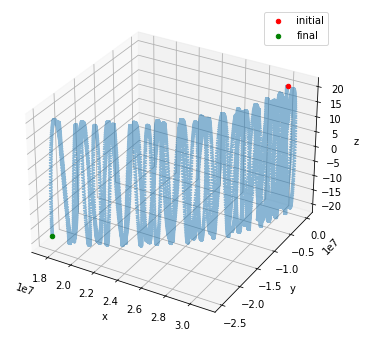

In [24]:
plot_position_updated_3d_simple(xtestpenning_p1[0:int(38540*15)],
                                ytestpenning_p1[0:int(38540*15)],
                                ztestpenning_p1[0:int(38540*15)],
                                rot=1, samp_rot=len(xtestpenning_p1[0:int(38540*15)])-1,
                                plot_sample=1, alpha=0.5, final=True, savefig=True)

### 3D Plot: Plot up to 15 rotations from the beginning without slicing

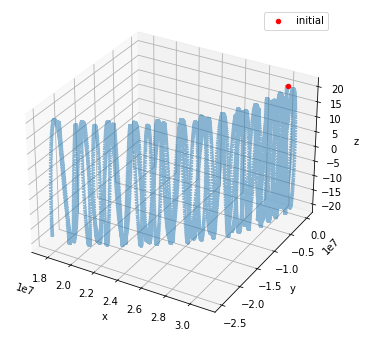

In [13]:
plot_position_updated_3d_simple(xtestpenning_p1, ytestpenning_p1, ztestpenning_p1,
                                rot=15, samp_rot=38540, plot_sample=1, alpha=0.5, final=False)

## 2D Plot
The user may want to see the 2D cross section of the motion. `plot_position_updated_2d_simple` serves that purpose. Additionally, this plotting function indicates the position of the particle at initial position, quarter of the first rotation, half of the first rotation, and final position.

## Plotting 2D up to first 15 rotations using slicing
This function is more primitive compared to 3D plotting. There is only option to plot with slices and not explicitly stating rotation. The `samp_rot` parameter is used to define the quarter and half rotations.

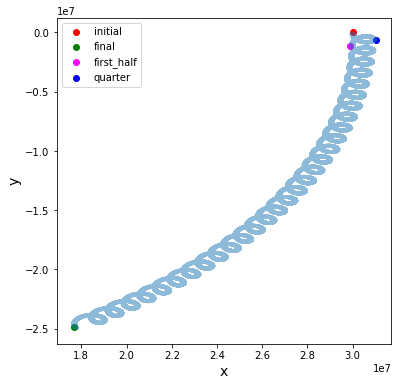

In [20]:
plot_position_updated_2d_simple(xtestpenning_p1[0:int(38540*15)], ytestpenning_p1[0:int(38540*15)], samp_rot=38540)

## Zooming into see cyclotron rotations.
The bold trajectory indicates the cyclotron rotations.

### Here is a zoomed version of the first 500 cyclotron iterations.
Because we have an initial velocity of 10000 it results in cyclotron radius of 100000 meters which is visually comparable with system size resulting in boldness.

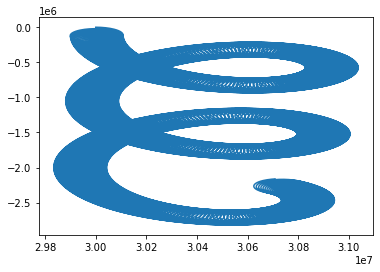

In [15]:
plt.plot(xtestpenning_p1[0:int(500*100)], ytestpenning_p1[0:int(500*100)])

### Zooming in even more, we can see the first 10 cyclotron motion

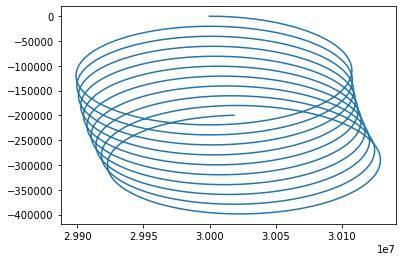

In [97]:
plt.plot(xtestpenning_p1[0:int(10*100)], ytestpenning_p1[0:int(10*100)])

### To get no boldness user can the decrease cyclotron radius by decreasing initial velocity.

## Creating A Misaligned Magnetic Field

In [7]:
# create 10 degree misaligned field
# azimuthal angle does not matter
B_10deg = create_magnetic_field(magnitude=1e-9, angle_from_z=10, phi=45)

In [8]:
# show the misaligned magnetic field vector that has the magntiude 10^-9 Tesla
B_10deg

(np.float64(1.2278780396897284e-10),
 np.float64(1.227878039689728e-10),
 np.float64(9.848077530122081e-10))